In [1]:
import os, code, sys, time
import numpy as np
import chainer
import chainer.functions as F
import chainer.links as L 
import chainer.optimizers as optimizers
import chainer.serializers as serializers
from chainer import cuda
import cupy
import matplotlib
import matplotlib.pyplot as plt
from IPython import display
from data_utils import load_data, normalize, next_minibatch

In [2]:
'''
Set array backend, seed
'''
rng_seed = 98765
use_gpu = True
xp = cupy if use_gpu >= 0 else np
print('xp: {}'.format(xp))
xp.random.seed(rng_seed)
np.random.seed(rng_seed)
print('rng_seed = {} '.format(rng_seed))

xp: <module 'cupy' from '/home/evan/.pyenv/versions/3.6.3/envs/P363/lib/python3.6/site-packages/cupy/__init__.py'>
rng_seed = 98765 


In [3]:
'''
Dataset parameters
'''
num_particles = 16 # defaults 16**3
zX = 0.4
zY = 0.0
zXb = 0.6
zYb = 0.2
print('Using redshifts z{}, z{}, with {} particles'.format(zX,zY,num_particles**3))

Using redshifts z0.4, z0.0, with 4096 particles


In [4]:
'''
Load training dataset
'''
X,Y = load_data(zX, zY, num_particles)
X = normalize(X)
Y = normalize(Y)
#Xb, Yb = load_data(zXb, zYb, num_particles)
#Xb = normalize(Xb)
#Yb = normalize(Yb)
print('X.shape: {}'.format(X.shape))

X.shape: (1000, 4096, 6)


In [5]:
'''
Pre-processing: nearest-neighbors and sparse adjacency
'''
from random import randrange
from numpy import linalg as LA
from sklearn.neighbors import kneighbors_graph
from sklearn.neighbors import NearestNeighbors
# returns adjacency lists based on NN in coordinate space

def adjacency_list_tf(X_in,k):
    shape_in = X_in.shape
    X_out = np.zeros([shape_in[0],shape_in[1],k],dtype=np.int32)
    for b in range(shape_in[0]):
        # this returns indices of the nn
        X_out[b] = kneighbors_graph(X_in[b,:,:3],k,include_self=True).indices.reshape([shape_in[1],k])
        #print(X_out[b].shape)
    return X_out


def get_adjacency_list(X_in,k):
    """ search for k nneighbors, and return offsetted indices in adjacency list
    
    Args:
        X_in: input data of shape (mb_size, N, 6)
        k: number of nearest neighbors
    """
    mb_size, N, D = X_in.shape
    X_out = np.zeros([mb_size, N, k],dtype=np.int32)
    for b in range(mb_size):
        # this returns indices of the nn
        graph_idx = kneighbors_graph(X_in[b,:,:3],k,include_self=True).indices.reshape([N,k]) + (N * b)
        X_out[b] = graph_idx
    return X_out


# adjacency list to proper index list for get_item
def alist_to_indexlist(alist):
    """ tiles batch indices to adjacency list for tf.gather
    """
    b, n, k = alist.shape
    #b = alist.shape[0] # batch size
    #n = alist.shape[1] # set size
    #k = alist.shape[2] # number of nn
    id1 = np.reshape(np.arange(b),[b,1])
    id1 = np.tile(id1,n*k).flatten()
    out = np.stack([id1,alist.flatten()],axis=1)
    return out

def nneighbors_graph(X_in, alist, n_NN=30):
    """ gets nneighbors for data, indexing from adjacency list indices
    
    Args:
        X_in: input data of shape (mb_size, N, 6)
        alist: adjacency list for X_in of shape (mb_size, N, num_NN)
    """   
    mb_size, N, D = X_in.shape
    n_NN = alist.shape[-1]
    xr = F.reshape(X_in, (-1,D))
    graph = F.reshape(F.get_item(xr, alist.flatten()), (mb_size, N, n_NN, D))
    return graph

In [6]:
'''
nn
'''
class SetLinear(chainer.Chain):
    """ Permutation equivariant linear layer for set data

    Args:
        kdim: channel size tuple (k_in, k_out)
        nobias: if True, no bias weights used
    """
    def __init__(self, kdim, nobias=False):
        self.kdim = kdim
        super(SetLinear, self).__init__(
            lin1 = L.Linear(kdim[0], kdim[1], nobias=nobias),
            )
        # Linear link wraps Wx+b function
        # can specify weight-init function with initialW=chainer.initializers.*

    def __call__(self, x, alist=None, n_NN=None, add=False):
        # alist and n_NN placeholders, not to be used here
        mb_size, N, D = x.shape
        k_in, k_out  = self.kdim
        x_mean = F.broadcast_to(F.mean(x, axis=1, keepdims=True),x.shape)
        #x_max  = F.broadcast_to(F.max(x, axis=1, keepdims=True),x.shape)
        x_r = F.reshape(x - x_mean, (mb_size*N, k_in))
        x1 = self.lin1(x_r)
        if add and k_in == k_out: x1 += x_r # shouldn't this be += x ?
        x_out = F.reshape(x1, (mb_size,N,k_out))  
        return x_out

class GraphSubset(chainer.Chain):
    """ graph subset layer, consists of two sets of permutation
        equivariant weights for graph and data
    
        Args:
            kdim: channel size tuple (k_in, k_out)
            nobias: if True, no bias weights used
        """
    def __init__(self, kdim, nobias=True):
        self.kdim = kdim
        super(GraphSubset, self).__init__(
            setlayer1 = SetLinear(kdim, nobias=nobias),
            setlayer2 = SetLinear(kdim, nobias=nobias),
            )
        
    def __call__(self, X_in, alist, n_NN, add=False):
        # CAREFUL WITH SKIP CONNECTION REDUNDANCY
        x0 = F.mean(nneighbors_graph(X_in, alist, n_NN), axis=2)
        x1 = self.setlayer1(X_in)
        x2 = self.setlayer2(x0)
        x_out = x1 + x2
        if add and self.kdim[0] == self.kdim[1]: x_out += X_in # is this the right place to have skips
        return x_out

In [7]:
'''
Models
'''
def get_sign(a):
    ones = xp.ones(a.shape).astype(xp.float32)
    negones = -1*xp.ones(a.shape).astype(xp.float32)
    zeros = xp.zeros(a.shape).astype(xp.float32)
    return F.where(a.data < 0, negones, F.where(a.data > 0, ones, zeros))

def get_readout(x_hat):
    readout = x_hat[...,:3]
    gt_one = ((get_sign(readout - 1) + 1)/2)
    ls_zero = -(get_sign(readout) - 1)/2
    rest = 1 - gt_one - ls_zero
    final = rest * readout + gt_one * (readout - 1) + ls_zero * (1 - readout)
    readout = final
    return readout

class nBodyModel(chainer.Chain):
    def __init__(self, channels, use_graph=False):
        self.channels = ch = channels
        self.use_graph = use_graph
        ch = [(ch[i],ch[i+1]) for i in range(0,len(ch)-1)]
        super(nBodyModel, self).__init__()
        layer = GraphSubset if use_graph else SetLinear
        # instantiate model layers
        for i in range(len(ch)):
            self.add_link('H' + str(i+1), layer(ch[i]))
                
    def __call__(self, x, alist=None, n_NN=None, activation=F.relu, add=True, bounded=False):
        if self.use_graph: assert alist is not None
        h = activation(self.H1(x, alist, n_NN)) # first layer
        for i in range(2,len(self.channels)): # forward through layers
            cur_layer = getattr(self, 'H' + str(i))
            h = cur_layer(h, alist, n_NN, add=add)
            if i != len(self.channels)-1: # activation on all except output layer
                h = activation(h)
        if add: h += x[...,:3]
        if not bounded: h = get_readout(h)
        return h 

print('models')

models


In [8]:
'''
Loss
'''
def loss_fun_readout(readout, x_true):
    # loss part
    x_true_loc = x_true[...,:3]
    dist = F.minimum(F.square(readout - x_true_loc), F.square(readout - (1 + x_true_loc)))
    dist = F.minimum(dist, F.square((1 + readout) - x_true_loc))
    # l2-dist
    loss = F.mean(F.sum(dist, axis=-1))
    return loss

def switch_loss(readout, x_true, pswitch=.7):
    """ switch between normal, unbounded loss function and
    bounded loss function with probability pswitch
    # terrible dont use
    """
    if pswitch > np.random.uniform(0,1):
        return loss_fun_bounded(readout, x_true)
    else:
        return loss_fun_readout(readout, x_true)

def get_bounded(x, bound):
    #gtb, ltb = bound, 1-bound
    lower, upper = bound, 1-bound
    gt = lower < x.data
    lt = x.data < upper
    bounded = xp.all(gt & lt, axis=-1) # shape should be (mb_size, 4096)
    return bounded

def loss_fun_bounded(readout, x_true, bound=0.1):
    # loss part
    x_true_loc = x_true[...,:3]
    bounded = get_bounded(x_true_loc, bound)
    #bounded = get_bounded(readout, bound)
    bdreadout = F.get_item(readout, bounded)
    bdx_true_loc = F.get_item(x_true_loc, bounded)
    dist_mse = F.mean(F.sum(F.square(bdreadout - bdx_true_loc), axis=-1))
    return dist_mse

def loss_fun_bounded2(readout, x_true, bound=0.1):
    # loss part
    x_true_loc = x_true[...,:3]
    bounded = get_bounded(x_true_loc, bound)
    unbounded = F.sum(F.square(readout - x_true_loc), axis=-1)
    zeros = xp.zeros_like(unbounded)
    bounded_diff = F.where(bounded, unbounded, zeros)
    dist_mse = F.mean(bounded_diff)
    return dist_mse

In [9]:
'''
Model and optimizer params
'''
#channels = [6,128,128,128,128,128,3] # 0
channels = [6, 8, 16, 32, 16, 8, 3, 8, 16, 32, 16, 8, 3] # lowest loss for graph model with 0.01 8
#channels = [6,32,3] # 0.000106 avg loss, 0.01, graph, 16 
lr = 0.01

In [10]:
'''
Initialize training model and optimizer
'''
use_graph = True
model = nBodyModel(channels, use_graph=use_graph)

if use_gpu: model.to_gpu() # can specify gpu device with device=*
adam = 'optimizer = optimizers.Adam(alpha={})'.format(lr)
opt = adam
print(opt)
exec(opt)
optimizer.setup(model)

optimizer = optimizers.Adam(alpha=0.01)


In [11]:
'''
Training vars
'''
# save directory
model_dir = './Models/'
interm_model_dir = model_dir + 'interm/'

# training vars
batch_size = 8
n_epochs = 2000
n_NN = 16

In [12]:
'''
Training setup
'''
# save directory
if not os.path.exists(interm_model_dir): os.makedirs(interm_model_dir)
print('save directory: {}'.format(model_dir))

x_in, x_true = next_minibatch([X,Y], batch_size)
print('batch.shape: {}'.format(x_in.shape))

'''
naming postfix convention:
|dataset|channels|batch_size|iterations|learning_rate|
eg: 16_0_64_1000_001
'''
model_name = 'graph_16_bi_8_2000_01_'
print('model_save_name: ' + model_name)

# loss container
loss_history = np.zeros((n_epochs), dtype=np.float32)
print('Session info: \nrng_seed: {}, ndarray_backend: {}'.format(rng_seed, xp))
print('redshifts: {}, num_particles: {}**3, data.shape: {}'.format((zX,zY), num_particles, X.shape))
print('n_epochs: {}, batch_size: {}, lr: {}'.format(n_epochs, batch_size, lr))
print('graph_model: {}, channels: {}, optimizer: {}'.format(use_graph, model.channels, opt))

save directory: ./Models/
batch.shape: (8, 4096, 6)
model_save_name: graph_16_bi_8_2000_01_
Session info: 
rng_seed: 98765, ndarray_backend: <module 'cupy' from '/home/evan/.pyenv/versions/3.6.3/envs/P363/lib/python3.6/site-packages/cupy/__init__.py'>
redshifts: (0.4, 0.0), num_particles: 16**3, data.shape: (1000, 4096, 6)
n_epochs: 2000, batch_size: 8, lr: 0.01
graph_model: True, channels: [6, 8, 16, 32, 16, 8, 3, 8, 16, 32, 16, 8, 3], optimizer: optimizer = optimizers.Adam(alpha=0.01)


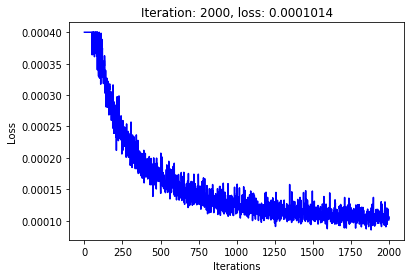

In [13]:
'''
Train loop
'''
from mpl_toolkits.mplot3d import Axes3D
plt.close('all')
#training_sets = ([X,Y], [Xb, Yb])
for epoch in range(1, n_epochs + 1, 1):
    t0 = time.time()
    model.zerograds()
    save_cond = (epoch % 10) == 0
    
    # create mini-batches for training
    _x_in, _x_true = next_minibatch([X,Y], batch_size)
    x_in = chainer.Variable(cuda.to_gpu(_x_in.astype(xp.float32)))
    x_true = chainer.Variable(cuda.to_gpu(_x_true.astype(xp.float32)))    
    
    # get prediction and loss
    nNN = alist = None
    if use_graph: 
        nNN = n_NN
        alist = get_adjacency_list(_x_in, nNN)
    x_hat = model(x_in, alist, nNN,add=True)#bounded=True) # prediction
    loss = loss_fun_readout(x_hat, x_true)
    
    # backprop and update
    loss.backward()
    optimizer.update()
    
    # save loss history
    loss_history[epoch-1] = cuda.to_cpu(loss.data)
    
    # Plot loss and save current model weights
    if save_cond:
        #print('{0:^4}    {1:^5}    {2:^4}'.format(epoch, loss_history[epoch-1], time.time()-t0))
        cur = str(epoch)
        np.save(model_dir + 'loss_history', loss_history)
        # plot loss
        plt.yscale('log')
        plt.grid(True)
        plt.clf()
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        y = loss_history[:epoch]
        yclip = .0004#np.mean(loss_history[:40])
        plt.plot(np.arange(epoch), np.clip(y,0,yclip), 'b-')
        #plt.yscale('linear')
        plt.title('Iteration: {0}, loss: {1:.4}'.format(epoch, loss_history[epoch-1]))
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(0.0001)
        
        if epoch % 50 == 0:
            serializers.save_npz(interm_model_dir + model_name + cur + '.model', model)
            serializers.save_npz(interm_model_dir + model_name + cur + '.state', optimizer)


In [14]:
'''
save train data
'''
xt = cuda.to_cpu(x_true.data)
xh = cuda.to_cpu(x_hat.data)
np.save(model_dir + model_name + 'train_input', _x_in)
np.save(model_dir + model_name + 'train_truth', xt)
np.save(model_dir + model_name + 'train_pred', xh)

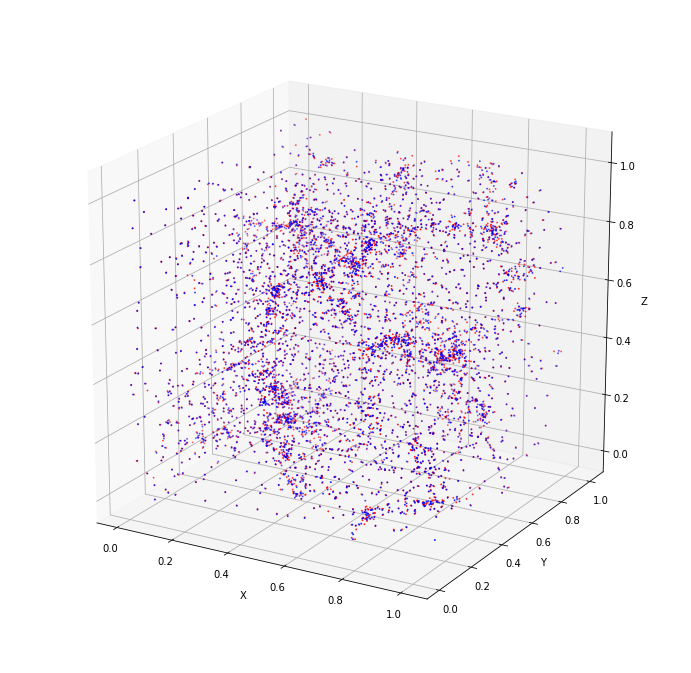

In [18]:
'''
plot
'''
from mpl_toolkits.mplot3d import Axes3D
xt_x = xt[:,:,0]
xt_y = xt[:,:,1]
xt_z = xt[:,:,2]

xh_x = xh[:,:,0]
xh_y = xh[:,:,1]
xh_z = xh[:,:,2]

j = 5
particle_size = .8
truth_color = 'b'
pred_color = 'r'

plt.close('all')
plt.clf()
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(111, projection='3d')
ax1.scatter(xt_x[j], xt_y[j], xt_z[j], s=particle_size,c=truth_color)
ax1.scatter(xh_x[j], xh_y[j], xh_z[j], s=particle_size,c=pred_color)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.view_init(20, 300)
display.display(plt.gcf())
display.clear_output(wait=True)
time.sleep(0.0001)

In [68]:
plt.close('all')

In [98]:
import mayavi
from mayavi import mlab
import numpy as np

"""
Note: this script is in it's own directory because it uses a different
      virtualenv to manage mayavi/vtk dependencies 
"""

def volumize_ptc(data_in, opacity=.5, labels=None, color=(1,0,0),frame=True, 
                 row=0, col=0, show=True, figure=None, proj=(False,True,True),
                 shadow=(False,True,True), mode='point', scale_factor=.015,
                 filename=None,):
    if figure is None:
        figure = mlab.figure(1, size=(400, 400), bgcolor=(0, 0, 0), fgcolor=(1, 0, 0))

    data = data_in.copy()
    data -= np.min(data, keepdims=True)
    data /= np.max(data, keepdims=True)
    data[:,0] += np.float(col)
    data[:,1] += np.float(row)
    xproj, yproj, zproj = proj
    xshadow, yshadow, zshadow = shadow
    if labels is None:
        pts = mlab.points3d(data[:,0], data[:,1], data[:,2], mode=mode, color=color, opacity=opacity, figure=figure, scale_factor=scale_factor)
        #mlab.pipeline.volume(mlab.pipeline.gaussian_splatter(pts, figure=figure))
        #pts = mlab.points3d(data[:,0], data[:,1], data[:,2], mode=mode, color=color, opacity=opacity, figure=figure, scale_mode='scalar', scale_factor=scale_factor)
        #pts = mlab.points3d(data[:,0], data[:,1], data[:,2], color=color, opacity=opacity, figure=figure, scale_factor=scale_factor)
    else:
        for l in np.unique(labels):
            color = tuple(list(np.random.rand(3)))
            ind = (labels == l).nonzero()[0]
            mlab.pipeline.volume(mlab.points3d(data[ind,0], data[ind,1], data[ind,2], 
                                               mode=mode, color=color, opacity=opacity))
    if frame:
        r_points = np.array([0,1,1,0,0,1,1,1,1,1,0,0,0,1,1,0,0,0]) + row + .0
        c_points = np.array([0,0,1,1,1,1,0,0,1,1,1,0,0,0,0,0,0,1]) + col +.0
        d_points = np.array([0,0,0,0,1,1,1,0,0,1,1,1,0,0,1,1,0,0]) +.0
        mlab.plot3d(c_points, r_points, d_points, representation='surface',
                    tube_radius=.003, line_width=1, figure=figure, opacity=.7, color=(1,1,1))

    #mlab.pipeline.volume(mlab.pipeline.gaussian_splatter(pts, figure=figure))
    mlab.view(azimuth=20, elevation=70, distance=3, focalpoint=None, roll=None, reset_roll=True, figure=figure)    
    if filename is not None:
        mlab.savefig(filename, size=(500,500), figure=figure, magnification='auto') 
        if not show: mlab.clf()
    if show: mlab.show()



def volumize_arrow(datain,# n x 3
                   arrow, #nx3
                 opacity=.5, labels=None,
                 color=(1,0,0),
                 frame=True, row=0, col=0,
                 show=True,
                 figure=None,
                 proj=(False,True,True),
                 shadow=(False,True,True),
                 mode='point',
                 scale_factor=.001,
                 filename=None,
                 normalize=False,
):
    if figure is None:
        figure = mlab.figure(1, size=(400, 400), bgcolor=(0, 0, 0), fgcolor=(1, 0, 0))

    data = datain.copy()
    if normalize:
        data -= np.min(data, keepdims=True)
        data /= np.max(data, keepdims=True)
    data[:,0] += np.float(col)
    data[:,1] += np.float(row)
    xproj,yproj,zproj = proj
    xshadow,yshadow,zshadow=shadow
    if labels is None:
        #pts = mlab.points3d(data[:,0], data[:,1], data[:,2], mode=mode, color=color, opacity=opacity, figure=figure, scale_factor=scale_factor)
        #mlab.pipeline.volume(mlab.pipeline.gaussian_splatter(pts, figure=figure))
        pts = mlab.quiver3d(data[:,0], data[:,1], data[:,2], arrow[:,0], arrow[:,1], arrow[:,2], color=color, opacity=opacity, figure=figure, mode=mode)
    else:
        for l in np.unique(labels):
            color = tuple(list(np.random.rand(3)))
            ind = (labels == l).nonzero()[0]
            mlab.pipeline.volume(mlab.points3d(data[ind,0], data[ind,1], data[ind,2], mode=mode, color=color, opacity=opacity))
    if frame:
        r_points = np.array([0,1,1,0,0,1,1,1,1,1,0,0,0,1,1,0,0,0]) + row + .0
        c_points = np.array([0,0,1,1,1,1,0,0,1,1,1,0,0,0,0,0,0,1]) + col +.0
        d_points = np.array([0,0,0,0,1,1,1,0,0,1,1,1,0,0,1,1,0,0]) +.0
        mlab.plot3d(c_points, r_points, d_points, representation='surface',tube_radius=.003, line_width=1, figure=figure, opacity=.7, color=(1,1,1))


    #mlab.pipeline.volume(mlab.pipeline.gaussian_splatter(pts, figure=figure))
    mlab.view(azimuth=20, elevation=70, distance=3, focalpoint=None, roll=None, reset_roll=True, figure=figure)    
    if filename is not None:
        mlab.savefig(filename, size=(500,500), figure=figure, magnification='auto') 
        if not show:
            mlab.clf()
    if show:
        mlab.show()


j = 3 # sample

x_input = _x_in
x_truth = xt
x_pred  = xh

xtmp = x_input[j,:,:3]
lower, upper = .1, 0.9
mask1 = np.logical_and(xtmp[:,0] < upper, xtmp[:,0] > lower) 
mask2 = np.logical_and(xtmp[:,1] < upper, xtmp[:,1] > lower) 
mask3 = np.logical_and(xtmp[:,2] < upper, xtmp[:,2] > lower) 
mask = mask1 * mask2 * mask3
mask_nz = np.nonzero(mask)[0]

fig = mlab.figure(1, size=(400, 400), bgcolor=(1, 1, 1), fgcolor=(1, 0, 0))
red   = (1,0,0)
green = (0,1,0)
blue  = (0,0,1)
arrow_mode = 'arrow'
sfactor = .005

displacement = np.mean((x_truth[:,mask_nz,:3] - x_input[:,mask_nz,:3]),axis=(1,2))
greatest = np.argmax(np.abs(displacement))
least = np.argmin(np.abs(displacement))
#j = greatest
#j = least
#print('displacement: {} at {}'.format(displacement[j], j))

arrow_true  = (x_input[j,mask_nz,:3], x_truth[j,mask_nz,:3] - x_input[j,mask_nz,:3])
arrow_input = (x_input[j,mask_nz,:3], x_input[j,mask_nz,3:])
arrow_pred  = (x_input[j,mask_nz,:3], x_pred[j, mask_nz,:3] - x_input[j,mask_nz,:3])
volumize_arrow(*arrow_true,  figure=fig, color=red,   opacity=.3, show=False, mode=arrow_mode)
volumize_arrow(*arrow_input, figure=fig, color=green, opacity=.3, show=False, mode=arrow_mode)
volumize_arrow(*arrow_pred,  figure=fig, color=blue,  opacity=.3, show=True,  mode=arrow_mode)
#volumize_ptc(x_truth[j,:,:3], show=False,figure=fig, opacity=.9, color=red,  mode='point', scale_factor=sfactor)
#volumize_ptc(x_input[j,:,:3], show=False,figure=fig, opacity=.9, color=green,mode='point', scale_factor=sfactor)
#volumize_ptc( x_pred[j,:,:3], show=True, figure=fig, opacity=.9, color=blue, mode='point', scale_factor=sfactor)



In [19]:
'''
Save current
'''
print('save {} loss history'.format(model_name))
np.save(model_dir + 'loss_history_' + model_name, loss_history)
serializers.save_npz(model_dir + model_name + '.model', model)
serializers.save_npz(model_dir + model_name + '.state', optimizer)

save graph_16_bi_8_2000_01_ loss history


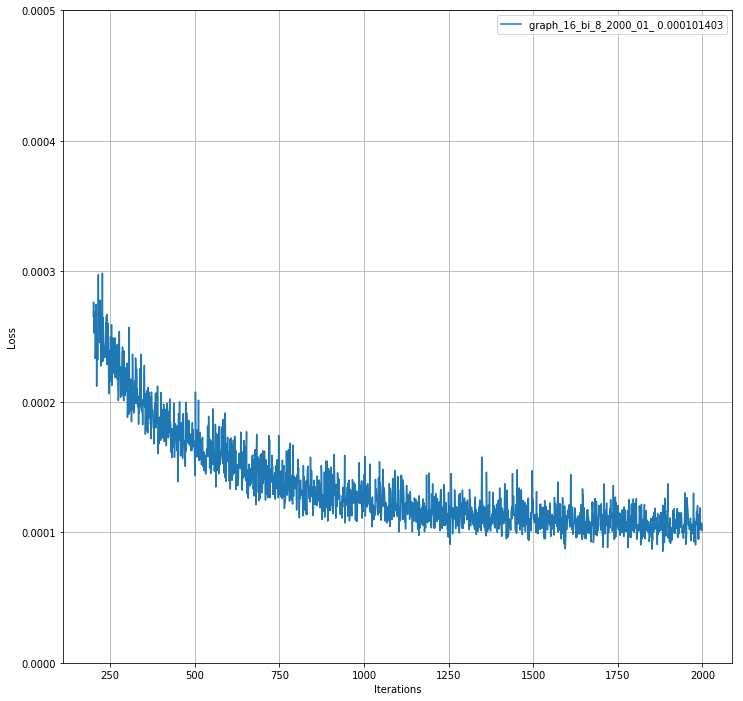

In [21]:
'''
Compare loss curves
'''
loss_labels = ['graph_16_bi_8_2000_01_',
               
              ]

loss_files = [np.load(model_dir + 'loss_history_' + fname + '.npy') for fname in loss_labels]
loss_curves = {label:loss for label,loss in zip(loss_labels, loss_files)}
iterations = np.arange(loss_files[0].shape[0])



plt.clf()
#plt.yscale('log')
plt.grid(True)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.ylim([0,.0005])
for label, loss in loss_curves.items():    
    plt.plot(iterations[200:], loss[200:], label=(label + ' ' + str(loss[-1])))

plt.legend()
plt.show()

In [22]:
"""
MODEL EVALUATION
"""
'''
Evaluation dataset
zX = 0.4
zY = 0.0
'''
zX_test = 0.4
zY_test = 0.0
X_test,Y_test = load_data(zX_test, zY_test, num_particles)
X_test = normalize(X_test)
Y_test = normalize(Y_test)
print('X_test.shape: {}'.format(X_test.shape))

X_test.shape: (1000, 4096, 6)


In [23]:
'''
Load trained model weights
'''
"""
test_model = nBodyModel(gchannels,graph=True)
print('Loading model from: ' + model_dir)
serializers.load_npz(model_dir + model_name + '.model', test_model)
if use_gpu: 
    print('using gpu')
    test_model.to_gpu()
"""
test_model = model

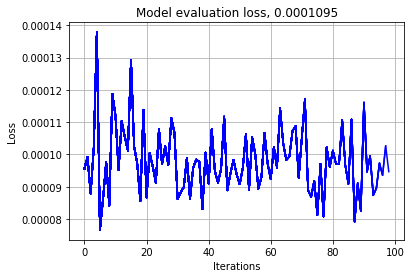

In [24]:
'''
Evaluation 
'''
test_mbs = 10
test_truth = np.zeros(X_test.shape[:-1] + (3,))
test_pred  = np.zeros(X_test.shape[:-1] + (3,))
test_loss_history = np.zeros(X_test.shape[0] // test_mbs)

num_iter = 0
plt.clf()
with chainer.using_config('train', False):
    for i in range(0, X_test.shape[0], test_mbs):
        # get X_in X_true
        x_in = X_test[i:i+test_mbs].astype(np.float32)
        alist = get_adjacency_list(x_in, n_NN)
        x_in = chainer.Variable(cuda.to_gpu(x_in))
        x_true = chainer.Variable(cuda.to_gpu(Y_test[i:i+test_mbs].astype(xp.float32)))
        x_hat = test_model(x_in, alist, n_NN)
        
        # calculate loss
        #test_loss = loss_fun_readout(x_hat, x_true)
        test_loss = loss_fun_bounded(x_hat, x_true)
        test_loss_history[num_iter] = cuda.to_cpu(test_loss.data)
        
        # plot loss
        plt.grid(True)
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        
        plt.plot(np.arange(num_iter), test_loss_history[:num_iter], 'b-')
        plt.title('Model evaluation loss, {0:.4}'.format(test_loss_history[num_iter]))
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(0.0001)        
        
        # store predictions
        test_truth[i:i+test_mbs] = cuda.to_cpu(x_true.data[...,:3])
        test_pred[i:i+test_mbs] = cuda.to_cpu(x_hat.data)
        
        num_iter += 1

In [25]:
'''
Save model predictions
'''
save_dir = './Evaluation/'
if not os.path.exists(save_dir): os.makedirs(save_dir)
#test_save_name = 'GraphModel_beta1_16'
test_save_name = model_name
np.save(save_dir + test_save_name + '_truth', test_truth)
np.save(save_dir + test_save_name + '_pred', test_pred)

In [26]:
'''
Matplotlib 3D plot
'''
from mpl_toolkits.mplot3d import Axes3D
xt = test_truth[...,:3]
xh = test_pred[...,:3]
xt_x = xt[:,:,0]
xt_y = xt[:,:,1]
xt_z = xt[:,:,2]

xh_x = xh[:,:,0]
xh_y = xh[:,:,1]
xh_z = xh[:,:,2]

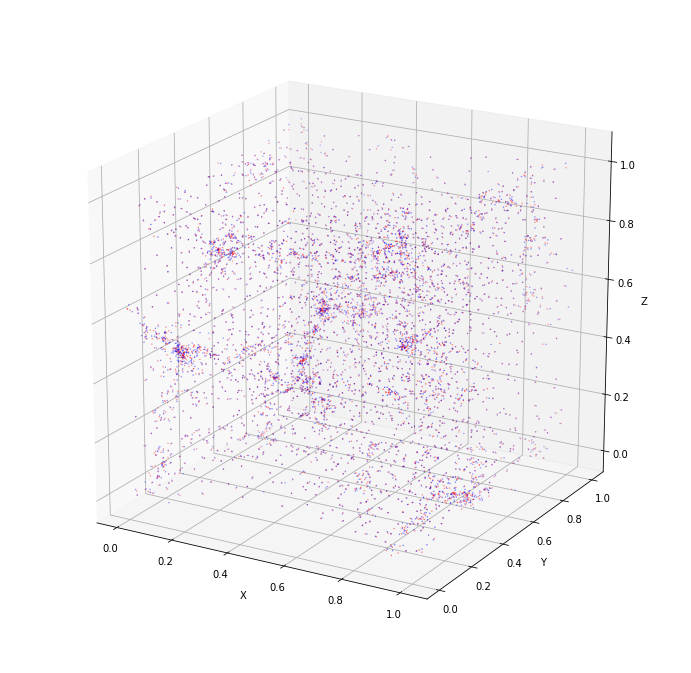

In [29]:
'''
plot
'''
j = 800
particle_size = .1
truth_color = 'r'
pred_color = 'b'
text_color = 'k'

plt.close('all')
plt.clf()
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(111, projection='3d')
ax1.scatter(xt_x[j], xt_y[j], xt_z[j], s=particle_size,c=truth_color)
ax1.scatter(xh_x[j], xh_y[j], xh_z[j], s=particle_size,c=pred_color)
ax1.set_xlabel('X', color=text_color)
ax1.set_ylabel('Y', color=text_color)
ax1.set_zlabel('Z', color=text_color)
#fig.patch.set_facecolor('k')
#ax1.set_facecolor('k')
ax1.view_init(20, 300)
display.display(plt.gcf())
display.clear_output(wait=True)
time.sleep(0.0001)

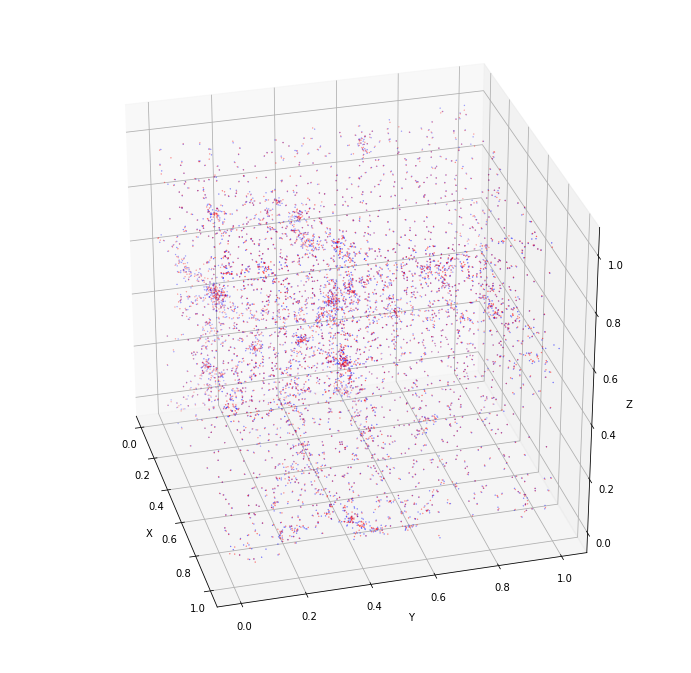

In [30]:
for angle in range(0,360,15):
    ax1.view_init(30, angle)
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [130]:
fig.savefig(save_dir + test_save_name, dpi=2400,bbox_inches='tight') # warning, this makes a huge image